In [3]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt


In [4]:
def compute_shannon_entropy(values, bins=10, epsilon=1e-10):
    """
    Compute Shannon entropy for a set of values by binning them.
    Adds a tiny constant (epsilon) to every bin to preserve zeros (which may represent sleep).
    """
    counts, _ = np.histogram(values, bins=bins)
    # Add epsilon to each bin count so that 0's become epsilon
    counts = counts + epsilon
    total = counts.sum()
    if total > 0:
        probabilities = counts / total
        # (No need to filter zeros since we replaced them)
        return entropy(probabilities, base=2)
    else:
        return np.nan


In [5]:
# Read one subject's CSV file (for testing)
df = pd.read_csv("\\\\itf-rs-store24.hpc.uiowa.edu\\vosslabhpc\\symposia\\cpsy-25\\temp\\GGIR\\sub-11\\output_sub-207\\meta\\csv\\207_(2015-07-08)RAW.csv.RData.csv")

# Convert the 'timestamp' column to datetime and create a 'date' column (floored to midnight)
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
df['date'] = df['timestamp'].dt.floor('D')

# Optional: inspect the unique dates to ensure the splicing is correct.
print("Unique dates in the data:", df['date'].unique())

# Aggregate ENMO for each day by computing daily Shannon entropy
daily_entropy = df.groupby('date').apply(
    lambda group: pd.Series({
        'time_interval': f"{group.name} to {group.name + pd.Timedelta(days=1)}",
        'shannon_entropy': compute_shannon_entropy(group['ENMO'], bins=10)
    })
).reset_index()

print("Daily summary:")
print(daily_entropy)


Unique dates in the data: <DatetimeArray>
['2015-07-08 00:00:00+00:00', '2015-07-09 00:00:00+00:00',
 '2015-07-10 00:00:00+00:00', '2015-07-11 00:00:00+00:00',
 '2015-07-12 00:00:00+00:00', '2015-07-13 00:00:00+00:00',
 '2015-07-14 00:00:00+00:00', '2015-07-15 00:00:00+00:00']
Length: 8, dtype: datetime64[ns, UTC]
Daily summary:
                       date  \
0 2015-07-08 00:00:00+00:00   
1 2015-07-09 00:00:00+00:00   
2 2015-07-10 00:00:00+00:00   
3 2015-07-11 00:00:00+00:00   
4 2015-07-12 00:00:00+00:00   
5 2015-07-13 00:00:00+00:00   
6 2015-07-14 00:00:00+00:00   
7 2015-07-15 00:00:00+00:00   

                                       time_interval  shannon_entropy  
0  2015-07-08 00:00:00+00:00 to 2015-07-09 00:00:...         1.102900  
1  2015-07-09 00:00:00+00:00 to 2015-07-10 00:00:...         1.094347  
2  2015-07-10 00:00:00+00:00 to 2015-07-11 00:00:...         0.420170  
3  2015-07-11 00:00:00+00:00 to 2015-07-12 00:00:...         0.594309  
4  2015-07-12 00:00:00+00:00 

C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\522852623.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_entropy = df.groupby('date').apply(


In [6]:
# Use the daily entropy values to compute meta entropy for this subject
n_bins = min(10, len(daily_entropy))
subject_meta_entropy = compute_shannon_entropy(daily_entropy['shannon_entropy'], bins=n_bins)

print("Subject Meta Entropy:", subject_meta_entropy)


Subject Meta Entropy: 2.500000000891549


In [7]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.stats import entropy

# Define glob patterns for each study using raw strings
better_pattern = "\\\\itf-rs-store24.hpc.uiowa.edu\\vosslabhpc\\Projects\\BETTER\\3-Experiment\\2-data\\bids\\derivatives\\GGIR\\sub-GE*\\ses-pre\\beh\\output_beh\\meta\\csv\\*.csv.RData.csv"
extend_pattern = "\\\\itf-rs-store24.hpc.uiowa.edu\\vosslabhpc\\Projects\\BikeExtend\\3-Experiment\\2-Data\\BIDS\\derivatives\\GGIR_2.8.2\\sub-*\\ses-*/beh\\output_beh\\meta\\csv\\*.csv.RData.csv"
pacrd_pattern = "\\\\itf-rs-store24.hpc.uiowa.edu\\vosslabhpc\\symposia\\cpsy-25\\temp\\GGIR\\sub-*\\output_sub-*/meta\\csv\\*.csv.RData.csv"

# Find file paths for each study
better_files = glob.glob(better_pattern)
extend_files = glob.glob(extend_pattern)
pacrd_files  = glob.glob(pacrd_pattern)

print("BETTER files found:", len(better_files))
print("EXTEND files found:", len(extend_files))
print("PACRD files found:", len(pacrd_files))


def compute_shannon_entropy(values, bins=10, epsilon=1e-10):
    """
    Compute Shannon entropy for a set of values by binning them.
    Adds a tiny constant (epsilon) to each bin so that 0's become a very small number.
    """
    counts, _ = np.histogram(values, bins=bins)
    counts = counts + epsilon
    total = counts.sum()
    if total > 0:
        probabilities = counts / total
        return entropy(probabilities, base=2)
    else:
        return np.nan


def process_subject(csv_path, bins=10):
    """
    Process a subject's CSV file and return the daily summary and meta entropy.
    Meta entropy is computed as the Shannon entropy of the normalized daily entropy values.
    """
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading {csv_path}: {e}")
        return None, None

    # Check if the 'timestamp' column exists
    if 'timestamp' not in df.columns:
        print(f"'timestamp' column not found in {csv_path}, skipping.")
        return None, None

    # Parse timestamps; unparseable values become NaT
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
    
    # Skip file if all timestamps failed to parse
    if df['timestamp'].isna().all():
        print(f"All timestamps in {csv_path} could not be parsed, skipping.")
        return None, None
    
    # Drop rows with NaT timestamps
    df = df.dropna(subset=['timestamp'])
    
    # Floor the timestamp to create a 'date' column (grouping by day)
    if pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['date'] = df['timestamp'].dt.floor('D')
    else:
        print(f"Timestamp column in {csv_path} is not datetime after parsing, skipping.")
        return None, None

    # Group by the floored date and compute daily Shannon entropy of the ENMO values
    daily_summary = df.groupby('date', group_keys=False).apply(
        lambda group: pd.Series({
            'time_interval': f"{group.name} to {group.name + pd.Timedelta(days=1)}",
            'shannon_entropy': compute_shannon_entropy(group['ENMO'], bins=bins)
        })
    ).reset_index()

    # Calculate meta entropy: normalize daily entropy values then compute entropy of that distribution
    daily_entropy_values = daily_summary['shannon_entropy'].values
    if daily_entropy_values.sum() > 0:
        meta_ent = entropy(daily_entropy_values / daily_entropy_values.sum(), base=2)
    else:
        meta_ent = np.nan

    return daily_summary, meta_ent


# A helper function to extract a subject identifier from the file path
def get_subject_id(file_path):
    # You can customize this extraction logic as needed.
    return os.path.basename(file_path)


# Create a list to store summary information for each subject
subject_summary = []

# Process subjects for each study and collect meta entropy values.
for study, file_list in [("BETTER", better_files), ("EXTEND", extend_files), ("PACRD", pacrd_files)]:
    for file in file_list:
        print(f"Processing {study} file: {file}")
        _, meta_ent = process_subject(file)
        if meta_ent is not None:
            subject_id = get_subject_id(file)
            subject_summary.append({
                "study": study,
                "subject_id": subject_id,
                "meta_entropy": meta_ent
            })

# Convert the summary list into a DataFrame
summary_df = pd.DataFrame(subject_summary)

# Display the summary DataFrame
print(summary_df.head())

# Optionally, save the summary DataFrame to a CSV file
summary_df.to_csv("meta_entropy_summary_all_subjects.csv", index=False)
print("Saved summary to meta_entropy_summary_all_subjects.csv")



BETTER files found: 65
EXTEND files found: 681
PACRD files found: 71
Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120001\ses-pre\beh\output_beh\meta\csv\sub-GE120001_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120002\ses-pre\beh\output_beh\meta\csv\sub-GE120002_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120003\ses-pre\beh\output_beh\meta\csv\sub-GE120003_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120004\ses-pre\beh\output_beh\meta\csv\sub-GE120004_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120005\ses-pre\beh\output_beh\meta\csv\sub-GE120005_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120006\ses-pre\beh\output_beh\meta\csv\sub-GE120006_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120008\ses-pre\beh\output_beh\meta\csv\sub-GE120008_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120010\ses-pre\beh\output_beh\meta\csv\sub-GE120010_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120011\ses-pre\beh\output_beh\meta\csv\sub-GE120011_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120012\ses-pre\beh\output_beh\meta\csv\sub-GE120012_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120013\ses-pre\beh\output_beh\meta\csv\sub-GE120013_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120014\ses-pre\beh\output_beh\meta\csv\sub-GE120014_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120015\ses-pre\beh\output_beh\meta\csv\sub-GE120015_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120017\ses-pre\beh\output_beh\meta\csv\sub-GE120017_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120018\ses-pre\beh\output_beh\meta\csv\sub-GE120018_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120019\ses-pre\beh\output_beh\meta\csv\sub-GE120019_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120020\ses-pre\beh\output_beh\meta\csv\sub-GE120020_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120021\ses-pre\beh\output_beh\meta\csv\sub-GE120021_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120023\ses-pre\beh\output_beh\meta\csv\sub-GE120023_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120024\ses-pre\beh\output_beh\meta\csv\sub-GE120024_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120025\ses-pre\beh\output_beh\meta\csv\sub-GE120025_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120026\ses-pre\beh\output_beh\meta\csv\sub-GE120026_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120027\ses-pre\beh\output_beh\meta\csv\sub-GE120027_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120028\ses-pre\beh\output_beh\meta\csv\sub-GE120028_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120029\ses-pre\beh\output_beh\meta\csv\sub-GE120029_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120030\ses-pre\beh\output_beh\meta\csv\sub-GE120030_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120031\ses-pre\beh\output_beh\meta\csv\sub-GE120031_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120032\ses-pre\beh\output_beh\meta\csv\sub-GE120032_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120033\ses-pre\beh\output_beh\meta\csv\sub-GE120033_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120034\ses-pre\beh\output_beh\meta\csv\sub-GE120034_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120035\ses-pre\beh\output_beh\meta\csv\sub-GE120035_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120036\ses-pre\beh\output_beh\meta\csv\sub-GE120036_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120039\ses-pre\beh\output_beh\meta\csv\sub-GE120039_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120040\ses-pre\beh\output_beh\meta\csv\sub-GE120040_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120041\ses-pre\beh\output_beh\meta\csv\sub-GE120041_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120042\ses-pre\beh\output_beh\meta\csv\sub-GE120042_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120043\ses-pre\beh\output_beh\meta\csv\sub-GE120043_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120044\ses-pre\beh\output_beh\meta\csv\sub-GE120044_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120045\ses-pre\beh\output_beh\meta\csv\sub-GE120045_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120047\ses-pre\beh\output_beh\meta\csv\sub-GE120047_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120050\ses-pre\beh\output_beh\meta\csv\sub-GE120050_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120052\ses-pre\beh\output_beh\meta\csv\sub-GE120052_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120053\ses-pre\beh\output_beh\meta\csv\sub-GE120053_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120054\ses-pre\beh\output_beh\meta\csv\sub-GE120054_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120055\ses-pre\beh\output_beh\meta\csv\sub-GE120055_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120057\ses-pre\beh\output_beh\meta\csv\sub-GE120057_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120058\ses-pre\beh\output_beh\meta\csv\sub-GE120058_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120061\ses-pre\beh\output_beh\meta\csv\sub-GE120061_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120062\ses-pre\beh\output_beh\meta\csv\sub-GE120062_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120063\ses-pre\beh\output_beh\meta\csv\sub-GE120063_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120065\ses-pre\beh\output_beh\meta\csv\sub-GE120065_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120068\ses-pre\beh\output_beh\meta\csv\sub-GE120068_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120069\ses-pre\beh\output_beh\meta\csv\sub-GE120069_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120070\ses-pre\beh\output_beh\meta\csv\sub-GE120070_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120073\ses-pre\beh\output_beh\meta\csv\sub-GE120073_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120075\ses-pre\beh\output_beh\meta\csv\sub-GE120075_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120076\ses-pre\beh\output_beh\meta\csv\sub-GE120076_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120077\ses-pre\beh\output_beh\meta\csv\sub-GE120077_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120078\ses-pre\beh\output_beh\meta\csv\sub-GE120078_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120079\ses-pre\beh\output_beh\meta\csv\sub-GE120079_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120080\ses-pre\beh\output_beh\meta\csv\sub-GE120080_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120081\ses-pre\beh\output_beh\meta\csv\sub-GE120081_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120082\ses-pre\beh\output_beh\meta\csv\sub-GE120082_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120083\ses-pre\beh\output_beh\meta\csv\sub-GE120083_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing BETTER file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120084\ses-pre\beh\output_beh\meta\csv\sub-GE120084_ses-pre_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2002\ses-accel1\beh\output_beh\meta\csv\sub-2002_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2002\ses-accel2\beh\output_beh\meta\csv\sub-2002_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2002\ses-accel3\beh\output_beh\meta\csv\sub-2002_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2002\ses-accel4\beh\output_beh\meta\csv\sub-2002_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2002\ses-accel5\beh\output_beh\meta\csv\sub-2002_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2002\ses-accel6\beh\output_beh\meta\csv\sub-2002_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2002\ses-accel7\beh\output_beh\meta\csv\sub-2002_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2002\ses-accel8\beh\output_beh\meta\csv\sub-2002_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2002\ses-accel9\beh\output_beh\meta\csv\sub-2002_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2009\ses-accel1\beh\output_beh\meta\csv\sub-2009_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2020\ses-accel1\beh\output_beh\meta\csv\sub-2020_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2020\ses-accel2\beh\output_beh\meta\csv\sub-2020_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2020\ses-accel3\beh\output_beh\meta\csv\sub-2020_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2020\ses-accel4\beh\output_beh\meta\csv\sub-2020_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2020\ses-accel5\beh\output_beh\meta\csv\sub-2020_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2020\ses-accel6\beh\output_beh\meta\csv\sub-2020_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2020\ses-accel7\beh\output_beh\meta\csv\sub-2020_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2020\ses-accel8\beh\output_beh\meta\csv\sub-2020_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2020\ses-accel9\beh\output_beh\meta\csv\sub-2020_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2041\ses-accel1\beh\output_beh\meta\csv\sub-2041_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2041\ses-accel2\beh\output_beh\meta\csv\sub-2041_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2041\ses-accel3\beh\output_beh\meta\csv\sub-2041_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2041\ses-accel4\beh\output_beh\meta\csv\sub-2041_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2041\ses-accel5\beh\output_beh\meta\csv\sub-2041_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2041\ses-accel6\beh\output_beh\meta\csv\sub-2041_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2041\ses-accel7\beh\output_beh\meta\csv\sub-2041_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2041\ses-accel8\beh\output_beh\meta\csv\sub-2041_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2042\ses-accel1\beh\output_beh\meta\csv\sub-2042_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2042\ses-accel2\beh\output_beh\meta\csv\sub-2042_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2042\ses-accel3\beh\output_beh\meta\csv\sub-2042_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2042\ses-accel4\beh\output_beh\meta\csv\sub-2042_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2042\ses-accel5\beh\output_beh\meta\csv\sub-2042_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2042\ses-accel6\beh\output_beh\meta\csv\sub-2042_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2042\ses-accel7\beh\output_beh\meta\csv\sub-2042_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2042\ses-accel8\beh\output_beh\meta\csv\sub-2042_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2053\ses-accel1\beh\output_beh\meta\csv\sub-2053_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2053\ses-accel2\beh\output_beh\meta\csv\sub-2053_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2053\ses-accel3\beh\output_beh\meta\csv\sub-2053_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2053\ses-accel4\beh\output_beh\meta\csv\sub-2053_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2053\ses-accel5\beh\output_beh\meta\csv\sub-2053_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2053\ses-accel6\beh\output_beh\meta\csv\sub-2053_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2053\ses-accel7\beh\output_beh\meta\csv\sub-2053_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2053\ses-accel8\beh\output_beh\meta\csv\sub-2053_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2053\ses-accel9\beh\output_beh\meta\csv\sub-2053_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2056\ses-accel1\beh\output_beh\meta\csv\sub-2056_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2056\ses-accel2\beh\output_beh\meta\csv\sub-2056_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2056\ses-accel3\beh\output_beh\meta\csv\sub-2056_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2056\ses-accel4\beh\output_beh\meta\csv\sub-2056_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2056\ses-accel5\beh\output_beh\meta\csv\sub-2056_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2056\ses-accel6\beh\output_beh\meta\csv\sub-2056_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2056\ses-accel7\beh\output_beh\meta\csv\sub-2056_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2056\ses-accel8\beh\output_beh\meta\csv\sub-2056_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2056\ses-accel9\beh\output_beh\meta\csv\sub-2056_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2057\ses-accel1\beh\output_beh\meta\csv\sub-2057_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2057\ses-accel2\beh\output_beh\meta\csv\sub-2057_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2057\ses-accel3\beh\output_beh\meta\csv\sub-2057_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2057\ses-accel4\beh\output_beh\meta\csv\sub-2057_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2057\ses-accel5\beh\output_beh\meta\csv\sub-2057_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2057\ses-accel6\beh\output_beh\meta\csv\sub-2057_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2057\ses-accel7\beh\output_beh\meta\csv\sub-2057_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2057\ses-accel8\beh\output_beh\meta\csv\sub-2057_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2057\ses-accel9\beh\output_beh\meta\csv\sub-2057_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2064\ses-accel1\beh\output_beh\meta\csv\sub-2064_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2064\ses-accel2\beh\output_beh\meta\csv\sub-2064_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2064\ses-accel3\beh\output_beh\meta\csv\sub-2064_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2064\ses-accel4\beh\output_beh\meta\csv\sub-2064_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2064\ses-accel5\beh\output_beh\meta\csv\sub-2064_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2064\ses-accel6\beh\output_beh\meta\csv\sub-2064_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2064\ses-accel7\beh\output_beh\meta\csv\sub-2064_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2064\ses-accel8\beh\output_beh\meta\csv\sub-2064_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2065\ses-accel1\beh\output_beh\meta\csv\sub-2065_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2065\ses-accel2\beh\output_beh\meta\csv\sub-2065_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2065\ses-accel3\beh\output_beh\meta\csv\sub-2065_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2065\ses-accel4\beh\output_beh\meta\csv\sub-2065_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2065\ses-accel5\beh\output_beh\meta\csv\sub-2065_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2065\ses-accel6\beh\output_beh\meta\csv\sub-2065_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2065\ses-accel7\beh\output_beh\meta\csv\sub-2065_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2065\ses-accel8\beh\output_beh\meta\csv\sub-2065_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2085\ses-accel1\beh\output_beh\meta\csv\sub-2085_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2085\ses-accel2\beh\output_beh\meta\csv\sub-2085_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2095\ses-accel1\beh\output_beh\meta\csv\sub-2095_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2100\ses-accel1\beh\output_beh\meta\csv\sub-2100_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2100\ses-accel2\beh\output_beh\meta\csv\sub-2100_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2100\ses-accel3\beh\output_beh\meta\csv\sub-2100_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2100\ses-accel4\beh\output_beh\meta\csv\sub-2100_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2100\ses-accel5\beh\output_beh\meta\csv\sub-2100_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2100\ses-accel6\beh\output_beh\meta\csv\sub-2100_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2100\ses-accel7\beh\output_beh\meta\csv\sub-2100_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2100\ses-accel8\beh\output_beh\meta\csv\sub-2100_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2100\ses-accel9\beh\output_beh\meta\csv\sub-2100_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2102\ses-accel1\beh\output_beh\meta\csv\sub-2102_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2103\ses-accel1\beh\output_beh\meta\csv\sub-2103_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2103\ses-accel2\beh\output_beh\meta\csv\sub-2103_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2103\ses-accel3\beh\output_beh\meta\csv\sub-2103_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2103\ses-accel4\beh\output_beh\meta\csv\sub-2103_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2103\ses-accel5\beh\output_beh\meta\csv\sub-2103_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2103\ses-accel6\beh\output_beh\meta\csv\sub-2103_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2103\ses-accel7\beh\output_beh\meta\csv\sub-2103_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2103\ses-accel8\beh\output_beh\meta\csv\sub-2103_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2105\ses-accel1\beh\output_beh\meta\csv\sub-2105_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2106\ses-accel1\beh\output_beh\meta\csv\sub-2106_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2106\ses-accel2\beh\output_beh\meta\csv\sub-2106_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2112\ses-accel1\beh\output_beh\meta\csv\sub-2112_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2112\ses-accel2\beh\output_beh\meta\csv\sub-2112_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2112\ses-accel3\beh\output_beh\meta\csv\sub-2112_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2112\ses-accel4\beh\output_beh\meta\csv\sub-2112_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2112\ses-accel5\beh\output_beh\meta\csv\sub-2112_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2112\ses-accel6\beh\output_beh\meta\csv\sub-2112_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2112\ses-accel7\beh\output_beh\meta\csv\sub-2112_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2112\ses-accel8\beh\output_beh\meta\csv\sub-2112_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2117\ses-accel1\beh\output_beh\meta\csv\sub-2117_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2118\ses-accel1\beh\output_beh\meta\csv\sub-2118_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2118\ses-accel2\beh\output_beh\meta\csv\sub-2118_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2118\ses-accel3\beh\output_beh\meta\csv\sub-2118_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2118\ses-accel4\beh\output_beh\meta\csv\sub-2118_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2118\ses-accel5\beh\output_beh\meta\csv\sub-2118_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2118\ses-accel6\beh\output_beh\meta\csv\sub-2118_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2118\ses-accel7\beh\output_beh\meta\csv\sub-2118_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2118\ses-accel8\beh\output_beh\meta\csv\sub-2118_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2118\ses-accel9\beh\output_beh\meta\csv\sub-2118_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2120\ses-accel1\beh\output_beh\meta\csv\sub-2120_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2120\ses-accel2\beh\output_beh\meta\csv\sub-2120_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2120\ses-accel3\beh\output_beh\meta\csv\sub-2120_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2120\ses-accel4\beh\output_beh\meta\csv\sub-2120_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2120\ses-accel5\beh\output_beh\meta\csv\sub-2120_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2120\ses-accel6\beh\output_beh\meta\csv\sub-2120_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2120\ses-accel7\beh\output_beh\meta\csv\sub-2120_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2120\ses-accel8\beh\output_beh\meta\csv\sub-2120_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2121\ses-accel1\beh\output_beh\meta\csv\sub-2121_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2121\ses-accel2\beh\output_beh\meta\csv\sub-2121_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2121\ses-accel3\beh\output_beh\meta\csv\sub-2121_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2121\ses-accel4\beh\output_beh\meta\csv\sub-2121_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2121\ses-accel5\beh\output_beh\meta\csv\sub-2121_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2121\ses-accel6\beh\output_beh\meta\csv\sub-2121_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2121\ses-accel7\beh\output_beh\meta\csv\sub-2121_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2121\ses-accel8\beh\output_beh\meta\csv\sub-2121_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2122\ses-accel1\beh\output_beh\meta\csv\sub-2122_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2122\ses-accel2\beh\output_beh\meta\csv\sub-2122_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2122\ses-accel3\beh\output_beh\meta\csv\sub-2122_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2122\ses-accel4\beh\output_beh\meta\csv\sub-2122_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2122\ses-accel5\beh\output_beh\meta\csv\sub-2122_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2122\ses-accel6\beh\output_beh\meta\csv\sub-2122_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2122\ses-accel7\beh\output_beh\meta\csv\sub-2122_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2122\ses-accel8\beh\output_beh\meta\csv\sub-2122_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2122\ses-accel9\beh\output_beh\meta\csv\sub-2122_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2125\ses-accel1\beh\output_beh\meta\csv\sub-2125_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2125\ses-accel2\beh\output_beh\meta\csv\sub-2125_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2125\ses-accel3\beh\output_beh\meta\csv\sub-2125_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2125\ses-accel4\beh\output_beh\meta\csv\sub-2125_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2125\ses-accel5\beh\output_beh\meta\csv\sub-2125_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2125\ses-accel6\beh\output_beh\meta\csv\sub-2125_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2125\ses-accel7\beh\output_beh\meta\csv\sub-2125_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2125\ses-accel8\beh\output_beh\meta\csv\sub-2125_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2127\ses-accel1\beh\output_beh\meta\csv\sub-2127_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2127\ses-accel2\beh\output_beh\meta\csv\sub-2127_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2127\ses-accel3\beh\output_beh\meta\csv\sub-2127_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2127\ses-accel4\beh\output_beh\meta\csv\sub-2127_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2127\ses-accel5\beh\output_beh\meta\csv\sub-2127_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2127\ses-accel6\beh\output_beh\meta\csv\sub-2127_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2127\ses-accel7\beh\output_beh\meta\csv\sub-2127_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2127\ses-accel8\beh\output_beh\meta\csv\sub-2127_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2129\ses-accel1\beh\output_beh\meta\csv\sub-2129_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2129\ses-accel2\beh\output_beh\meta\csv\sub-2129_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2129\ses-accel3\beh\output_beh\meta\csv\sub-2129_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2129\ses-accel4\beh\output_beh\meta\csv\sub-2129_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2129\ses-accel5\beh\output_beh\meta\csv\sub-2129_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2129\ses-accel6\beh\output_beh\meta\csv\sub-2129_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2129\ses-accel7\beh\output_beh\meta\csv\sub-2129_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2129\ses-accel8\beh\output_beh\meta\csv\sub-2129_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2131\ses-accel1\beh\output_beh\meta\csv\sub-2131_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2131\ses-accel2\beh\output_beh\meta\csv\sub-2131_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2131\ses-accel3\beh\output_beh\meta\csv\sub-2131_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2131\ses-accel4\beh\output_beh\meta\csv\sub-2131_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2131\ses-accel5\beh\output_beh\meta\csv\sub-2131_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2131\ses-accel6\beh\output_beh\meta\csv\sub-2131_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2131\ses-accel7\beh\output_beh\meta\csv\sub-2131_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2131\ses-accel8\beh\output_beh\meta\csv\sub-2131_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2137\ses-accel1\beh\output_beh\meta\csv\sub-2137_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2137\ses-accel2\beh\output_beh\meta\csv\sub-2137_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2137\ses-accel3\beh\output_beh\meta\csv\sub-2137_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2137\ses-accel4\beh\output_beh\meta\csv\sub-2137_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2137\ses-accel5\beh\output_beh\meta\csv\sub-2137_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2137\ses-accel6\beh\output_beh\meta\csv\sub-2137_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2137\ses-accel7\beh\output_beh\meta\csv\sub-2137_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2137\ses-accel8\beh\output_beh\meta\csv\sub-2137_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2137\ses-accel9\beh\output_beh\meta\csv\sub-2137_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2143\ses-accel1\beh\output_beh\meta\csv\sub-2143_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2145\ses-accel1\beh\output_beh\meta\csv\sub-2145_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2145\ses-accel2\beh\output_beh\meta\csv\sub-2145_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2145\ses-accel3\beh\output_beh\meta\csv\sub-2145_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2145\ses-accel4\beh\output_beh\meta\csv\sub-2145_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2145\ses-accel5\beh\output_beh\meta\csv\sub-2145_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2145\ses-accel6\beh\output_beh\meta\csv\sub-2145_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2145\ses-accel7\beh\output_beh\meta\csv\sub-2145_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2145\ses-accel8\beh\output_beh\meta\csv\sub-2145_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2148\ses-accel1\beh\output_beh\meta\csv\sub-2148_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2149\ses-accel1\beh\output_beh\meta\csv\sub-2149_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2149\ses-accel2\beh\output_beh\meta\csv\sub-2149_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2149\ses-accel3\beh\output_beh\meta\csv\sub-2149_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2149\ses-accel4\beh\output_beh\meta\csv\sub-2149_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2149\ses-accel5\beh\output_beh\meta\csv\sub-2149_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2149\ses-accel6\beh\output_beh\meta\csv\sub-2149_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2149\ses-accel7\beh\output_beh\meta\csv\sub-2149_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2149\ses-accel8\beh\output_beh\meta\csv\sub-2149_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2149\ses-accel9\beh\output_beh\meta\csv\sub-2149_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2156\ses-accel1\beh\output_beh\meta\csv\sub-2156_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2156\ses-accel2\beh\output_beh\meta\csv\sub-2156_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2156\ses-accel3\beh\output_beh\meta\csv\sub-2156_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2156\ses-accel4\beh\output_beh\meta\csv\sub-2156_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2156\ses-accel5\beh\output_beh\meta\csv\sub-2156_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2156\ses-accel6\beh\output_beh\meta\csv\sub-2156_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2156\ses-accel7\beh\output_beh\meta\csv\sub-2156_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2156\ses-accel8\beh\output_beh\meta\csv\sub-2156_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2156\ses-accel9\beh\output_beh\meta\csv\sub-2156_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2167\ses-accel1\beh\output_beh\meta\csv\sub-2167_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2167\ses-accel3\beh\output_beh\meta\csv\sub-2167_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2167\ses-accel4\beh\output_beh\meta\csv\sub-2167_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2167\ses-accel5\beh\output_beh\meta\csv\sub-2167_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2167\ses-accel6\beh\output_beh\meta\csv\sub-2167_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2167\ses-accel7\beh\output_beh\meta\csv\sub-2167_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2167\ses-accel8\beh\output_beh\meta\csv\sub-2167_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2175\ses-accel1\beh\output_beh\meta\csv\sub-2175_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2175\ses-accel2\beh\output_beh\meta\csv\sub-2175_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2175\ses-accel3\beh\output_beh\meta\csv\sub-2175_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2175\ses-accel4\beh\output_beh\meta\csv\sub-2175_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2175\ses-accel5\beh\output_beh\meta\csv\sub-2175_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2175\ses-accel6\beh\output_beh\meta\csv\sub-2175_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2175\ses-accel7\beh\output_beh\meta\csv\sub-2175_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2175\ses-accel8\beh\output_beh\meta\csv\sub-2175_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2175\ses-accel9\beh\output_beh\meta\csv\sub-2175_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2185\ses-accel1\beh\output_beh\meta\csv\sub-2185_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2185\ses-accel2\beh\output_beh\meta\csv\sub-2185_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2185\ses-accel3\beh\output_beh\meta\csv\sub-2185_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2185\ses-accel4\beh\output_beh\meta\csv\sub-2185_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2185\ses-accel5\beh\output_beh\meta\csv\sub-2185_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2185\ses-accel6\beh\output_beh\meta\csv\sub-2185_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2185\ses-accel7\beh\output_beh\meta\csv\sub-2185_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2185\ses-accel8\beh\output_beh\meta\csv\sub-2185_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2185\ses-accel9\beh\output_beh\meta\csv\sub-2185_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2186\ses-accel1\beh\output_beh\meta\csv\sub-2186_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2186\ses-accel2\beh\output_beh\meta\csv\sub-2186_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2186\ses-accel3\beh\output_beh\meta\csv\sub-2186_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2186\ses-accel4\beh\output_beh\meta\csv\sub-2186_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2186\ses-accel5\beh\output_beh\meta\csv\sub-2186_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2186\ses-accel6\beh\output_beh\meta\csv\sub-2186_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2186\ses-accel7\beh\output_beh\meta\csv\sub-2186_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2186\ses-accel8\beh\output_beh\meta\csv\sub-2186_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2186\ses-accel9\beh\output_beh\meta\csv\sub-2186_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2197\ses-accel1\beh\output_beh\meta\csv\sub-2197_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2197\ses-accel2\beh\output_beh\meta\csv\sub-2197_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2197\ses-accel3\beh\output_beh\meta\csv\sub-2197_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2197\ses-accel4\beh\output_beh\meta\csv\sub-2197_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2197\ses-accel5\beh\output_beh\meta\csv\sub-2197_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2197\ses-accel6\beh\output_beh\meta\csv\sub-2197_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2197\ses-accel7\beh\output_beh\meta\csv\sub-2197_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2197\ses-accel8\beh\output_beh\meta\csv\sub-2197_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2199\ses-accel1\beh\output_beh\meta\csv\sub-2199_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2199\ses-accel2\beh\output_beh\meta\csv\sub-2199_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2199\ses-accel3\beh\output_beh\meta\csv\sub-2199_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2199\ses-accel4\beh\output_beh\meta\csv\sub-2199_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2199\ses-accel5\beh\output_beh\meta\csv\sub-2199_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2199\ses-accel6\beh\output_beh\meta\csv\sub-2199_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2199\ses-accel7\beh\output_beh\meta\csv\sub-2199_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2199\ses-accel8\beh\output_beh\meta\csv\sub-2199_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2201\ses-accel1\beh\output_beh\meta\csv\sub-2201_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2201\ses-accel2\beh\output_beh\meta\csv\sub-2201_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2201\ses-accel3\beh\output_beh\meta\csv\sub-2201_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2201\ses-accel4\beh\output_beh\meta\csv\sub-2201_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2201\ses-accel5\beh\output_beh\meta\csv\sub-2201_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2201\ses-accel6\beh\output_beh\meta\csv\sub-2201_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2201\ses-accel7\beh\output_beh\meta\csv\sub-2201_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2201\ses-accel8\beh\output_beh\meta\csv\sub-2201_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2206\ses-accel1\beh\output_beh\meta\csv\sub-2206_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2206\ses-accel2\beh\output_beh\meta\csv\sub-2206_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2206\ses-accel3\beh\output_beh\meta\csv\sub-2206_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2206\ses-accel4\beh\output_beh\meta\csv\sub-2206_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2206\ses-accel5\beh\output_beh\meta\csv\sub-2206_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2206\ses-accel6\beh\output_beh\meta\csv\sub-2206_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2206\ses-accel7\beh\output_beh\meta\csv\sub-2206_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2206\ses-accel8\beh\output_beh\meta\csv\sub-2206_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2211\ses-accel1\beh\output_beh\meta\csv\sub-2211_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2211\ses-accel2\beh\output_beh\meta\csv\sub-2211_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2211\ses-accel3\beh\output_beh\meta\csv\sub-2211_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2211\ses-accel4\beh\output_beh\meta\csv\sub-2211_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2211\ses-accel5\beh\output_beh\meta\csv\sub-2211_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2211\ses-accel7\beh\output_beh\meta\csv\sub-2211_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2211\ses-accel8\beh\output_beh\meta\csv\sub-2211_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2211\ses-accel9\beh\output_beh\meta\csv\sub-2211_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2218\ses-accel1\beh\output_beh\meta\csv\sub-2218_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2218\ses-accel2\beh\output_beh\meta\csv\sub-2218_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2218\ses-accel3\beh\output_beh\meta\csv\sub-2218_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2218\ses-accel4\beh\output_beh\meta\csv\sub-2218_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2218\ses-accel7\beh\output_beh\meta\csv\sub-2218_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2218\ses-accel8\beh\output_beh\meta\csv\sub-2218_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2218\ses-accel9\beh\output_beh\meta\csv\sub-2218_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2219\ses-accel1\beh\output_beh\meta\csv\sub-2219_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2219\ses-accel2\beh\output_beh\meta\csv\sub-2219_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2219\ses-accel3\beh\output_beh\meta\csv\sub-2219_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2219\ses-accel4\beh\output_beh\meta\csv\sub-2219_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2219\ses-accel5\beh\output_beh\meta\csv\sub-2219_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2219\ses-accel7\beh\output_beh\meta\csv\sub-2219_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2219\ses-accel8\beh\output_beh\meta\csv\sub-2219_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2219\ses-accel9\beh\output_beh\meta\csv\sub-2219_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2221\ses-accel2\beh\output_beh\meta\csv\sub-2221_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2221\ses-accel3\beh\output_beh\meta\csv\sub-2221_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2221\ses-accel4\beh\output_beh\meta\csv\sub-2221_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2221\ses-accel5\beh\output_beh\meta\csv\sub-2221_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2221\ses-accel6\beh\output_beh\meta\csv\sub-2221_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2221\ses-accel7\beh\output_beh\meta\csv\sub-2221_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2221\ses-accel8\beh\output_beh\meta\csv\sub-2221_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2224\ses-accel1\beh\output_beh\meta\csv\sub-2224_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2224\ses-accel2\beh\output_beh\meta\csv\sub-2224_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2224\ses-accel3\beh\output_beh\meta\csv\sub-2224_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2224\ses-accel4\beh\output_beh\meta\csv\sub-2224_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2224\ses-accel5\beh\output_beh\meta\csv\sub-2224_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2224\ses-accel6\beh\output_beh\meta\csv\sub-2224_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2224\ses-accel8\beh\output_beh\meta\csv\sub-2224_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2241\ses-accel1\beh\output_beh\meta\csv\sub-2241_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2241\ses-accel2\beh\output_beh\meta\csv\sub-2241_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2241\ses-accel3\beh\output_beh\meta\csv\sub-2241_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2241\ses-accel4\beh\output_beh\meta\csv\sub-2241_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2241\ses-accel5\beh\output_beh\meta\csv\sub-2241_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2241\ses-accel6\beh\output_beh\meta\csv\sub-2241_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2241\ses-accel7\beh\output_beh\meta\csv\sub-2241_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2241\ses-accel8\beh\output_beh\meta\csv\sub-2241_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2242\ses-accel1\beh\output_beh\meta\csv\sub-2242_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2242\ses-accel2\beh\output_beh\meta\csv\sub-2242_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2242\ses-accel3\beh\output_beh\meta\csv\sub-2242_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2242\ses-accel4\beh\output_beh\meta\csv\sub-2242_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2242\ses-accel5\beh\output_beh\meta\csv\sub-2242_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2242\ses-accel6\beh\output_beh\meta\csv\sub-2242_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2242\ses-accel7\beh\output_beh\meta\csv\sub-2242_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2242\ses-accel8\beh\output_beh\meta\csv\sub-2242_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2242\ses-accel9\beh\output_beh\meta\csv\sub-2242_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2259\ses-accel1\beh\output_beh\meta\csv\sub-2259_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2259\ses-accel2\beh\output_beh\meta\csv\sub-2259_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2259\ses-accel3\beh\output_beh\meta\csv\sub-2259_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2259\ses-accel4\beh\output_beh\meta\csv\sub-2259_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2259\ses-accel5\beh\output_beh\meta\csv\sub-2259_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2259\ses-accel6\beh\output_beh\meta\csv\sub-2259_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2259\ses-accel7\beh\output_beh\meta\csv\sub-2259_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2259\ses-accel8\beh\output_beh\meta\csv\sub-2259_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2259\ses-accel9\beh\output_beh\meta\csv\sub-2259_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2273\ses-accel1\beh\output_beh\meta\csv\sub-2273_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2273\ses-accel2\beh\output_beh\meta\csv\sub-2273_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2273\ses-accel8\beh\output_beh\meta\csv\sub-2273_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2273\ses-accel9\beh\output_beh\meta\csv\sub-2273_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2277\ses-accel1\beh\output_beh\meta\csv\sub-2277_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2277\ses-accel2\beh\output_beh\meta\csv\sub-2277_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2277\ses-accel3\beh\output_beh\meta\csv\sub-2277_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2277\ses-accel4\beh\output_beh\meta\csv\sub-2277_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2277\ses-accel8\beh\output_beh\meta\csv\sub-2277_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2277\ses-accel9\beh\output_beh\meta\csv\sub-2277_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2287\ses-accel1\beh\output_beh\meta\csv\sub-2287_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2287\ses-accel2\beh\output_beh\meta\csv\sub-2287_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2287\ses-accel3\beh\output_beh\meta\csv\sub-2287_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2287\ses-accel4\beh\output_beh\meta\csv\sub-2287_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2287\ses-accel5\beh\output_beh\meta\csv\sub-2287_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2287\ses-accel7\beh\output_beh\meta\csv\sub-2287_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2287\ses-accel9\beh\output_beh\meta\csv\sub-2287_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2295\ses-accel1\beh\output_beh\meta\csv\sub-2295_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2295\ses-accel2\beh\output_beh\meta\csv\sub-2295_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2295\ses-accel3\beh\output_beh\meta\csv\sub-2295_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2295\ses-accel4\beh\output_beh\meta\csv\sub-2295_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2295\ses-accel5\beh\output_beh\meta\csv\sub-2295_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2295\ses-accel6\beh\output_beh\meta\csv\sub-2295_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2295\ses-accel7\beh\output_beh\meta\csv\sub-2295_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2295\ses-accel8\beh\output_beh\meta\csv\sub-2295_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2295\ses-accel9\beh\output_beh\meta\csv\sub-2295_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2302\ses-accel1\beh\output_beh\meta\csv\sub-2302_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2302\ses-accel2\beh\output_beh\meta\csv\sub-2302_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2302\ses-accel3\beh\output_beh\meta\csv\sub-2302_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2302\ses-accel4\beh\output_beh\meta\csv\sub-2302_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2302\ses-accel5\beh\output_beh\meta\csv\sub-2302_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2302\ses-accel6\beh\output_beh\meta\csv\sub-2302_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2302\ses-accel8\beh\output_beh\meta\csv\sub-2302_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2307\ses-accel1\beh\output_beh\meta\csv\sub-2307_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2307\ses-accel2\beh\output_beh\meta\csv\sub-2307_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2307\ses-accel8\beh\output_beh\meta\csv\sub-2307_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2307\ses-accel9\beh\output_beh\meta\csv\sub-2307_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2314\ses-accel1\beh\output_beh\meta\csv\sub-2314_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2314\ses-accel2\beh\output_beh\meta\csv\sub-2314_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2314\ses-accel3\beh\output_beh\meta\csv\sub-2314_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2314\ses-accel4\beh\output_beh\meta\csv\sub-2314_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2314\ses-accel5\beh\output_beh\meta\csv\sub-2314_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2314\ses-accel7\beh\output_beh\meta\csv\sub-2314_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2314\ses-accel8\beh\output_beh\meta\csv\sub-2314_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2314\ses-accel9\beh\output_beh\meta\csv\sub-2314_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2316\ses-accel1\beh\output_beh\meta\csv\sub-2316_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2316\ses-accel2\beh\output_beh\meta\csv\sub-2316_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2316\ses-accel3\beh\output_beh\meta\csv\sub-2316_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2316\ses-accel4\beh\output_beh\meta\csv\sub-2316_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2316\ses-accel5\beh\output_beh\meta\csv\sub-2316_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2316\ses-accel6\beh\output_beh\meta\csv\sub-2316_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2316\ses-accel7\beh\output_beh\meta\csv\sub-2316_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2316\ses-accel8\beh\output_beh\meta\csv\sub-2316_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2328\ses-accel1\beh\output_beh\meta\csv\sub-2328_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2332\ses-accel1\beh\output_beh\meta\csv\sub-2332_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2332\ses-accel2\beh\output_beh\meta\csv\sub-2332_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2332\ses-accel3\beh\output_beh\meta\csv\sub-2332_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2332\ses-accel8\beh\output_beh\meta\csv\sub-2332_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2332\ses-accel9\beh\output_beh\meta\csv\sub-2332_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2353\ses-accel1\beh\output_beh\meta\csv\sub-2353_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2353\ses-accel2\beh\output_beh\meta\csv\sub-2353_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2353\ses-accel8\beh\output_beh\meta\csv\sub-2353_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2353\ses-accel9\beh\output_beh\meta\csv\sub-2353_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2385\ses-accel1\beh\output_beh\meta\csv\sub-2385_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2385\ses-accel2\beh\output_beh\meta\csv\sub-2385_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2385\ses-accel3\beh\output_beh\meta\csv\sub-2385_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2385\ses-accel4\beh\output_beh\meta\csv\sub-2385_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2385\ses-accel8\beh\output_beh\meta\csv\sub-2385_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2388\ses-accel1\beh\output_beh\meta\csv\sub-2388_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2388\ses-accel2\beh\output_beh\meta\csv\sub-2388_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2388\ses-accel3\beh\output_beh\meta\csv\sub-2388_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2388\ses-accel9\beh\output_beh\meta\csv\sub-2388_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2397\ses-accel1\beh\output_beh\meta\csv\sub-2397_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2397\ses-accel2\beh\output_beh\meta\csv\sub-2397_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2397\ses-accel3\beh\output_beh\meta\csv\sub-2397_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2397\ses-accel4\beh\output_beh\meta\csv\sub-2397_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2397\ses-accel8\beh\output_beh\meta\csv\sub-2397_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2397\ses-accel9\beh\output_beh\meta\csv\sub-2397_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2406\ses-accel1\beh\output_beh\meta\csv\sub-2406_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2406\ses-accel2\beh\output_beh\meta\csv\sub-2406_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2406\ses-accel3\beh\output_beh\meta\csv\sub-2406_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2406\ses-accel5\beh\output_beh\meta\csv\sub-2406_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2406\ses-accel8\beh\output_beh\meta\csv\sub-2406_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2406\ses-accel9\beh\output_beh\meta\csv\sub-2406_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2417\ses-accel1\beh\output_beh\meta\csv\sub-2417_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2417\ses-accel2\beh\output_beh\meta\csv\sub-2417_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2417\ses-accel3\beh\output_beh\meta\csv\sub-2417_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2417\ses-accel4\beh\output_beh\meta\csv\sub-2417_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2417\ses-accel6\beh\output_beh\meta\csv\sub-2417_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2417\ses-accel7\beh\output_beh\meta\csv\sub-2417_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2417\ses-accel9\beh\output_beh\meta\csv\sub-2417_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2422\ses-accel1\beh\output_beh\meta\csv\sub-2422_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2422\ses-accel2\beh\output_beh\meta\csv\sub-2422_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2422\ses-accel3\beh\output_beh\meta\csv\sub-2422_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2450\ses-accel1\beh\output_beh\meta\csv\sub-2450_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2450\ses-accel2\beh\output_beh\meta\csv\sub-2450_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2450\ses-accel8\beh\output_beh\meta\csv\sub-2450_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2452\ses-accel1\beh\output_beh\meta\csv\sub-2452_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2470\ses-accel1\beh\output_beh\meta\csv\sub-2470_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2480\ses-accel1\beh\output_beh\meta\csv\sub-2480_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2480\ses-accel3\beh\output_beh\meta\csv\sub-2480_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2480\ses-accel9\beh\output_beh\meta\csv\sub-2480_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2488\ses-accel1\beh\output_beh\meta\csv\sub-2488_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2488\ses-accel2\beh\output_beh\meta\csv\sub-2488_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2488\ses-accel4\beh\output_beh\meta\csv\sub-2488_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2488\ses-accel9\beh\output_beh\meta\csv\sub-2488_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2501\ses-accel1\beh\output_beh\meta\csv\sub-2501_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2521\ses-accel1\beh\output_beh\meta\csv\sub-2521_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2521\ses-accel2\beh\output_beh\meta\csv\sub-2521_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2525\ses-accel8\beh\output_beh\meta\csv\sub-2525_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2525\ses-accel9\beh\output_beh\meta\csv\sub-2525_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2550\ses-accel1\beh\output_beh\meta\csv\sub-2550_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2550\ses-accel2\beh\output_beh\meta\csv\sub-2550_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2553\ses-accel1\beh\output_beh\meta\csv\sub-2553_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2553\ses-accel2\beh\output_beh\meta\csv\sub-2553_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2554\ses-accel1\beh\output_beh\meta\csv\sub-2554_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2554\ses-accel2\beh\output_beh\meta\csv\sub-2554_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2554\ses-accel3\beh\output_beh\meta\csv\sub-2554_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2557\ses-accel1\beh\output_beh\meta\csv\sub-2557_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2557\ses-accel2\beh\output_beh\meta\csv\sub-2557_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2557\ses-accel3\beh\output_beh\meta\csv\sub-2557_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2557\ses-accel7\beh\output_beh\meta\csv\sub-2557_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2563\ses-accel1\beh\output_beh\meta\csv\sub-2563_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2563\ses-accel2\beh\output_beh\meta\csv\sub-2563_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2563\ses-accel3\beh\output_beh\meta\csv\sub-2563_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2563\ses-accel5\beh\output_beh\meta\csv\sub-2563_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2563\ses-accel6\beh\output_beh\meta\csv\sub-2563_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2563\ses-accel7\beh\output_beh\meta\csv\sub-2563_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2568\ses-accel1\beh\output_beh\meta\csv\sub-2568_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2568\ses-accel2\beh\output_beh\meta\csv\sub-2568_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2568\ses-accel6\beh\output_beh\meta\csv\sub-2568_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2572\ses-accel1\beh\output_beh\meta\csv\sub-2572_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2572\ses-accel2\beh\output_beh\meta\csv\sub-2572_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2572\ses-accel3\beh\output_beh\meta\csv\sub-2572_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2572\ses-accel4\beh\output_beh\meta\csv\sub-2572_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2572\ses-accel5\beh\output_beh\meta\csv\sub-2572_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2572\ses-accel6\beh\output_beh\meta\csv\sub-2572_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2579\ses-accel1\beh\output_beh\meta\csv\sub-2579_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2579\ses-accel2\beh\output_beh\meta\csv\sub-2579_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2579\ses-accel3\beh\output_beh\meta\csv\sub-2579_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2579\ses-accel5\beh\output_beh\meta\csv\sub-2579_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2580\ses-accel1\beh\output_beh\meta\csv\sub-2580_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2580\ses-accel2\beh\output_beh\meta\csv\sub-2580_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2580\ses-accel5\beh\output_beh\meta\csv\sub-2580_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2580\ses-accel7\beh\output_beh\meta\csv\sub-2580_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2583\ses-accel2\beh\output_beh\meta\csv\sub-2583_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2583\ses-accel3\beh\output_beh\meta\csv\sub-2583_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2583\ses-accel4\beh\output_beh\meta\csv\sub-2583_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2583\ses-accel5\beh\output_beh\meta\csv\sub-2583_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2583\ses-accel6\beh\output_beh\meta\csv\sub-2583_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2584\ses-accel1\beh\output_beh\meta\csv\sub-2584_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2584\ses-accel2\beh\output_beh\meta\csv\sub-2584_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2584\ses-accel4\beh\output_beh\meta\csv\sub-2584_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2584\ses-accel6\beh\output_beh\meta\csv\sub-2584_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2584\ses-accel7\beh\output_beh\meta\csv\sub-2584_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2594\ses-accel1\beh\output_beh\meta\csv\sub-2594_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2594\ses-accel2\beh\output_beh\meta\csv\sub-2594_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2594\ses-accel7\beh\output_beh\meta\csv\sub-2594_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2594\ses-accel9\beh\output_beh\meta\csv\sub-2594_ses-accel9_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2603\ses-accel2\beh\output_beh\meta\csv\sub-2603_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2603\ses-accel3\beh\output_beh\meta\csv\sub-2603_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2603\ses-accel5\beh\output_beh\meta\csv\sub-2603_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2603\ses-accel6\beh\output_beh\meta\csv\sub-2603_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2603\ses-accel7\beh\output_beh\meta\csv\sub-2603_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2608\ses-accel1\beh\output_beh\meta\csv\sub-2608_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2608\ses-accel2\beh\output_beh\meta\csv\sub-2608_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2608\ses-accel3\beh\output_beh\meta\csv\sub-2608_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2608\ses-accel4\beh\output_beh\meta\csv\sub-2608_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2608\ses-accel5\beh\output_beh\meta\csv\sub-2608_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2608\ses-accel6\beh\output_beh\meta\csv\sub-2608_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2608\ses-accel7\beh\output_beh\meta\csv\sub-2608_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2608\ses-accel8\beh\output_beh\meta\csv\sub-2608_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2609\ses-accel2\beh\output_beh\meta\csv\sub-2609_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2616\ses-accel2\beh\output_beh\meta\csv\sub-2616_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2616\ses-accel3\beh\output_beh\meta\csv\sub-2616_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2616\ses-accel4\beh\output_beh\meta\csv\sub-2616_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2616\ses-accel5\beh\output_beh\meta\csv\sub-2616_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2616\ses-accel6\beh\output_beh\meta\csv\sub-2616_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2629\ses-accel2\beh\output_beh\meta\csv\sub-2629_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2629\ses-accel4\beh\output_beh\meta\csv\sub-2629_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2629\ses-accel6\beh\output_beh\meta\csv\sub-2629_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2637\ses-accel2\beh\output_beh\meta\csv\sub-2637_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2637\ses-accel3\beh\output_beh\meta\csv\sub-2637_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2637\ses-accel4\beh\output_beh\meta\csv\sub-2637_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2637\ses-accel5\beh\output_beh\meta\csv\sub-2637_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2637\ses-accel6\beh\output_beh\meta\csv\sub-2637_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2637\ses-accel7\beh\output_beh\meta\csv\sub-2637_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2638\ses-accel2\beh\output_beh\meta\csv\sub-2638_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2638\ses-accel3\beh\output_beh\meta\csv\sub-2638_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2638\ses-accel4\beh\output_beh\meta\csv\sub-2638_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2638\ses-accel6\beh\output_beh\meta\csv\sub-2638_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2638\ses-accel7\beh\output_beh\meta\csv\sub-2638_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2638\ses-accel8\beh\output_beh\meta\csv\sub-2638_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2643\ses-accel2\beh\output_beh\meta\csv\sub-2643_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2643\ses-accel3\beh\output_beh\meta\csv\sub-2643_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2643\ses-accel4\beh\output_beh\meta\csv\sub-2643_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2643\ses-accel5\beh\output_beh\meta\csv\sub-2643_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2643\ses-accel6\beh\output_beh\meta\csv\sub-2643_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2643\ses-accel7\beh\output_beh\meta\csv\sub-2643_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2643\ses-accel8\beh\output_beh\meta\csv\sub-2643_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2646\ses-accel2\beh\output_beh\meta\csv\sub-2646_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2648\ses-accel1\beh\output_beh\meta\csv\sub-2648_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2648\ses-accel2\beh\output_beh\meta\csv\sub-2648_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2648\ses-accel3\beh\output_beh\meta\csv\sub-2648_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2648\ses-accel5\beh\output_beh\meta\csv\sub-2648_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2648\ses-accel6\beh\output_beh\meta\csv\sub-2648_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2653\ses-accel2\beh\output_beh\meta\csv\sub-2653_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2653\ses-accel3\beh\output_beh\meta\csv\sub-2653_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2653\ses-accel4\beh\output_beh\meta\csv\sub-2653_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2653\ses-accel5\beh\output_beh\meta\csv\sub-2653_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2653\ses-accel6\beh\output_beh\meta\csv\sub-2653_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2653\ses-accel7\beh\output_beh\meta\csv\sub-2653_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2653\ses-accel8\beh\output_beh\meta\csv\sub-2653_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2700\ses-accel2\beh\output_beh\meta\csv\sub-2700_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2700\ses-accel4\beh\output_beh\meta\csv\sub-2700_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2700\ses-accel5\beh\output_beh\meta\csv\sub-2700_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2700\ses-accel7\beh\output_beh\meta\csv\sub-2700_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2707\ses-accel2\beh\output_beh\meta\csv\sub-2707_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2717\ses-accel2\beh\output_beh\meta\csv\sub-2717_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2718\ses-accel2\beh\output_beh\meta\csv\sub-2718_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2718\ses-accel3\beh\output_beh\meta\csv\sub-2718_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2718\ses-accel4\beh\output_beh\meta\csv\sub-2718_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2718\ses-accel5\beh\output_beh\meta\csv\sub-2718_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2718\ses-accel8\beh\output_beh\meta\csv\sub-2718_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2738\ses-accel2\beh\output_beh\meta\csv\sub-2738_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2738\ses-accel4\beh\output_beh\meta\csv\sub-2738_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2738\ses-accel5\beh\output_beh\meta\csv\sub-2738_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2738\ses-accel6\beh\output_beh\meta\csv\sub-2738_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2738\ses-accel7\beh\output_beh\meta\csv\sub-2738_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2738\ses-accel8\beh\output_beh\meta\csv\sub-2738_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2739\ses-accel2\beh\output_beh\meta\csv\sub-2739_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2739\ses-accel3\beh\output_beh\meta\csv\sub-2739_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2739\ses-accel5\beh\output_beh\meta\csv\sub-2739_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2739\ses-accel7\beh\output_beh\meta\csv\sub-2739_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2742\ses-accel2\beh\output_beh\meta\csv\sub-2742_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2742\ses-accel4\beh\output_beh\meta\csv\sub-2742_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2742\ses-accel5\beh\output_beh\meta\csv\sub-2742_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2742\ses-accel6\beh\output_beh\meta\csv\sub-2742_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2742\ses-accel8\beh\output_beh\meta\csv\sub-2742_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2743\ses-accel3\beh\output_beh\meta\csv\sub-2743_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2743\ses-accel4\beh\output_beh\meta\csv\sub-2743_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2743\ses-accel5\beh\output_beh\meta\csv\sub-2743_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2743\ses-accel7\beh\output_beh\meta\csv\sub-2743_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2743\ses-accel8\beh\output_beh\meta\csv\sub-2743_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2745\ses-accel1\beh\output_beh\meta\csv\sub-2745_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2745\ses-accel2\beh\output_beh\meta\csv\sub-2745_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2745\ses-accel3\beh\output_beh\meta\csv\sub-2745_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2745\ses-accel4\beh\output_beh\meta\csv\sub-2745_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2745\ses-accel5\beh\output_beh\meta\csv\sub-2745_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2745\ses-accel6\beh\output_beh\meta\csv\sub-2745_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2745\ses-accel7\beh\output_beh\meta\csv\sub-2745_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2745\ses-accel8\beh\output_beh\meta\csv\sub-2745_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2762\ses-accel1\beh\output_beh\meta\csv\sub-2762_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2762\ses-accel2\beh\output_beh\meta\csv\sub-2762_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2762\ses-accel3\beh\output_beh\meta\csv\sub-2762_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2762\ses-accel4\beh\output_beh\meta\csv\sub-2762_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2762\ses-accel5\beh\output_beh\meta\csv\sub-2762_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2770\ses-accel1\beh\output_beh\meta\csv\sub-2770_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2770\ses-accel2\beh\output_beh\meta\csv\sub-2770_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2770\ses-accel3\beh\output_beh\meta\csv\sub-2770_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2770\ses-accel4\beh\output_beh\meta\csv\sub-2770_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2770\ses-accel7\beh\output_beh\meta\csv\sub-2770_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2774\ses-accel1\beh\output_beh\meta\csv\sub-2774_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2774\ses-accel2\beh\output_beh\meta\csv\sub-2774_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2774\ses-accel4\beh\output_beh\meta\csv\sub-2774_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2774\ses-accel5\beh\output_beh\meta\csv\sub-2774_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2774\ses-accel6\beh\output_beh\meta\csv\sub-2774_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2774\ses-accel7\beh\output_beh\meta\csv\sub-2774_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2774\ses-accel8\beh\output_beh\meta\csv\sub-2774_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2780\ses-accel1\beh\output_beh\meta\csv\sub-2780_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2780\ses-accel3\beh\output_beh\meta\csv\sub-2780_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2780\ses-accel4\beh\output_beh\meta\csv\sub-2780_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2780\ses-accel5\beh\output_beh\meta\csv\sub-2780_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2798\ses-accel1\beh\output_beh\meta\csv\sub-2798_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2798\ses-accel2\beh\output_beh\meta\csv\sub-2798_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2798\ses-accel3\beh\output_beh\meta\csv\sub-2798_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2798\ses-accel4\beh\output_beh\meta\csv\sub-2798_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2798\ses-accel5\beh\output_beh\meta\csv\sub-2798_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2798\ses-accel7\beh\output_beh\meta\csv\sub-2798_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2798\ses-accel8\beh\output_beh\meta\csv\sub-2798_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2801\ses-accel1\beh\output_beh\meta\csv\sub-2801_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2801\ses-accel2\beh\output_beh\meta\csv\sub-2801_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2801\ses-accel5\beh\output_beh\meta\csv\sub-2801_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2801\ses-accel7\beh\output_beh\meta\csv\sub-2801_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2808\ses-accel2\beh\output_beh\meta\csv\sub-2808_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2808\ses-accel3\beh\output_beh\meta\csv\sub-2808_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2808\ses-accel4\beh\output_beh\meta\csv\sub-2808_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2808\ses-accel5\beh\output_beh\meta\csv\sub-2808_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2808\ses-accel7\beh\output_beh\meta\csv\sub-2808_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2813\ses-accel2\beh\output_beh\meta\csv\sub-2813_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2813\ses-accel4\beh\output_beh\meta\csv\sub-2813_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2813\ses-accel5\beh\output_beh\meta\csv\sub-2813_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2820\ses-accel2\beh\output_beh\meta\csv\sub-2820_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2820\ses-accel3\beh\output_beh\meta\csv\sub-2820_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2820\ses-accel4\beh\output_beh\meta\csv\sub-2820_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2820\ses-accel5\beh\output_beh\meta\csv\sub-2820_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2820\ses-accel6\beh\output_beh\meta\csv\sub-2820_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2820\ses-accel8\beh\output_beh\meta\csv\sub-2820_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2823\ses-accel2\beh\output_beh\meta\csv\sub-2823_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2823\ses-accel3\beh\output_beh\meta\csv\sub-2823_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2823\ses-accel5\beh\output_beh\meta\csv\sub-2823_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2823\ses-accel8\beh\output_beh\meta\csv\sub-2823_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2826\ses-accel2\beh\output_beh\meta\csv\sub-2826_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2826\ses-accel3\beh\output_beh\meta\csv\sub-2826_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2826\ses-accel4\beh\output_beh\meta\csv\sub-2826_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2826\ses-accel5\beh\output_beh\meta\csv\sub-2826_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2826\ses-accel6\beh\output_beh\meta\csv\sub-2826_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2833\ses-accel2\beh\output_beh\meta\csv\sub-2833_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2833\ses-accel4\beh\output_beh\meta\csv\sub-2833_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2833\ses-accel5\beh\output_beh\meta\csv\sub-2833_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2833\ses-accel6\beh\output_beh\meta\csv\sub-2833_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2833\ses-accel7\beh\output_beh\meta\csv\sub-2833_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2833\ses-accel8\beh\output_beh\meta\csv\sub-2833_ses-accel8_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2841\ses-accel2\beh\output_beh\meta\csv\sub-2841_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2841\ses-accel3\beh\output_beh\meta\csv\sub-2841_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2841\ses-accel4\beh\output_beh\meta\csv\sub-2841_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2841\ses-accel5\beh\output_beh\meta\csv\sub-2841_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2841\ses-accel6\beh\output_beh\meta\csv\sub-2841_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2842\ses-accel2\beh\output_beh\meta\csv\sub-2842_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2842\ses-accel3\beh\output_beh\meta\csv\sub-2842_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2842\ses-accel4\beh\output_beh\meta\csv\sub-2842_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2846\ses-accel2\beh\output_beh\meta\csv\sub-2846_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2846\ses-accel3\beh\output_beh\meta\csv\sub-2846_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2859\ses-accel1\beh\output_beh\meta\csv\sub-2859_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2859\ses-accel2\beh\output_beh\meta\csv\sub-2859_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2859\ses-accel4\beh\output_beh\meta\csv\sub-2859_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2859\ses-accel5\beh\output_beh\meta\csv\sub-2859_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2859\ses-accel6\beh\output_beh\meta\csv\sub-2859_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2859\ses-accel7\beh\output_beh\meta\csv\sub-2859_ses-accel7_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2861\ses-accel1\beh\output_beh\meta\csv\sub-2861_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2861\ses-accel2\beh\output_beh\meta\csv\sub-2861_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2861\ses-accel3\beh\output_beh\meta\csv\sub-2861_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2861\ses-accel4\beh\output_beh\meta\csv\sub-2861_ses-accel4_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2861\ses-accel5\beh\output_beh\meta\csv\sub-2861_ses-accel5_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2874\ses-accel1\beh\output_beh\meta\csv\sub-2874_ses-accel1_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2874\ses-accel2\beh\output_beh\meta\csv\sub-2874_ses-accel2_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2874\ses-accel3\beh\output_beh\meta\csv\sub-2874_ses-accel3_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BikeExtend\3-Experiment\2-Data\BIDS\derivatives\GGIR_2.8.2\sub-2874\ses-accel6\beh\output_beh\meta\csv\sub-2874_ses-accel6_accel.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-10\output_sub-311\meta\csv\311_(2015-06-26)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-102\output_sub-498\meta\csv\498_(2015-07-21)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-104\output_sub-566\meta\csv\566_(2016-02-24)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-11\output_sub-207\meta\csv\207_(2015-07-08)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-110\output_sub-560\meta\csv\560_(2016-02-24)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-113\output_sub-565\meta\csv\565_(2016-03-02)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-12\output_sub-68\meta\csv\68_(2015-06-23)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-13\output_sub-200\meta\csv\200_(2015-07-02)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-132\output_sub-599\meta\csv\599_(2016-07-01)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-133\output_sub-598\meta\csv\598_(2016-06-24)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-135\output_sub-600\meta\csv\600_(2016-07-08)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-136\output_sub-601\meta\csv\601_(2019-02-19)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-140\output_sub-605\meta\csv\605_(2016-07-09)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-143\output_sub-607\meta\csv\607_(2016-07-15)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-144\output_sub-608\meta\csv\608_(2016-07-21)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-146\output_sub-625\meta\csv\625_(2016-08-30)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-149\output_sub-616\meta\csv\616_(2016-08-04)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-154\output_sub-621\meta\csv\621_(2016-07-30)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-158\output_sub-628\meta\csv\628_(2016-08-10)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-159\output_sub-629\meta\csv\629_(2016-08-25)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-161\output_sub-634\meta\csv\634_(2016-08-20)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-164\output_sub-659\meta\csv\659_(2016-10-05)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-166\output_sub-649\meta\csv\649_(2019-01-16)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-172\output_sub-656\meta\csv\656_(2016-09-27)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-174\output_sub-669\meta\csv\669_(2020-03-11)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-176\output_sub-671\meta\csv\671_(2016-10-22)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-178\output_sub-655\meta\csv\655_(2016-09-21)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-182\output_sub-666\meta\csv\666_(2016-10-06)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-185\output_sub-658\meta\csv\658_(2016-10-19)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-186\output_sub-667\meta\csv\667_(2016-10-21)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-190\output_sub-670\meta\csv\670_(2016-10-18)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-191\output_sub-675\meta\csv\675_(2016-10-29)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-195\output_sub-677\meta\csv\677_(2016-12-01)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-197\output_sub-674\meta\csv\674_(2016-11-03)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-199\output_sub-676\meta\csv\676_(2016-11-01)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-202\output_sub-678\meta\csv\678_(2016-11-02)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-204\output_sub-684\meta\csv\684_(2016-11-15)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-206\output_sub-687\meta\csv\687_(2016-11-19)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-208\output_sub-695\meta\csv\695_(2016-12-23)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-209\output_sub-713\meta\csv\713_(2017-01-19)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-24\output_sub-500\meta\csv\500_(2015-07-10)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-25\output_sub-58\meta\csv\58_(2015-07-09)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-31\output_sub-182\meta\csv\182_(2015-07-10)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-39\output_sub-503\meta\csv\503_(2015-07-31)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-41\output_sub-45\meta\csv\45_(2015-07-14)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-43\output_sub-505\meta\csv\505_(2015-07-15)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-44\output_sub-508\meta\csv\508_(2015-08-25)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-45\output_sub-522\meta\csv\522_(2015-09-09)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-46\output_sub-507\meta\csv\507_(2017-08-19)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-5\output_sub-644\meta\csv\644_(2016-10-22)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-51\output_sub-157\meta\csv\157_(2015-08-22)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-52\output_sub-217\meta\csv\217_(2015-08-19)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-55\output_sub-234\meta\csv\234_(2015-08-14)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-56\output_sub-519\meta\csv\519_(2015-08-21)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-6\output_sub-201\meta\csv\201_(2015-06-24)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-64\output_sub-525\meta\csv\525_(2017-01-21)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-65\output_sub-526\meta\csv\526_(2015-09-24)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-66\output_sub-527\meta\csv\527_(2015-09-29)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-7\output_sub-87\meta\csv\87_(2015-06-26)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-74\output_sub-538\meta\csv\538_(2015-11-03)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-76\output_sub-553\meta\csv\553_(2016-01-15)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-77\output_sub-537\meta\csv\537_(2015-11-07)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-78\output_sub-534\meta\csv\534_(2015-10-22)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-8\output_sub-44\meta\csv\44_(2015-08-28)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-83\output_sub-540\meta\csv\540_(2015-11-10)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-86\output_sub-549\meta\csv\549_(2015-12-01)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-87\output_sub-542\meta\csv\542_(2015-11-14)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-89\output_sub-541\meta\csv\541_(2015-11-12)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-9\output_sub-92\meta\csv\92_(2015-07-16)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-92\output_sub-547\meta\csv\547_(2015-11-24)RAW.csv.RData.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing PACRD file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\symposia\cpsy-25\temp\GGIR\sub-98\output_sub-552\meta\csv\552_(2015-12-16)RAW.csv.RData.csv
    study                                subject_id  meta_entropy
0  BETTER  sub-GE120001_ses-pre_accel.csv.RData.csv      2.955153
1  BETTER  sub-GE120002_ses-pre_accel.csv.RData.csv      2.924345
2  BETTER  sub-GE120003_ses-pre_accel.csv.RData.csv      2.853231
3  BETTER  sub-GE120004_ses-pre_accel.csv.RData.csv      2.889990
4  BETTER  sub-GE120005_ses-pre_accel.csv.RData.csv      2.888399
Saved summary to meta_entropy_summary_all_subjects.csv


C:\Users\jedim\AppData\Local\Temp\ipykernel_2556\4078523351.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


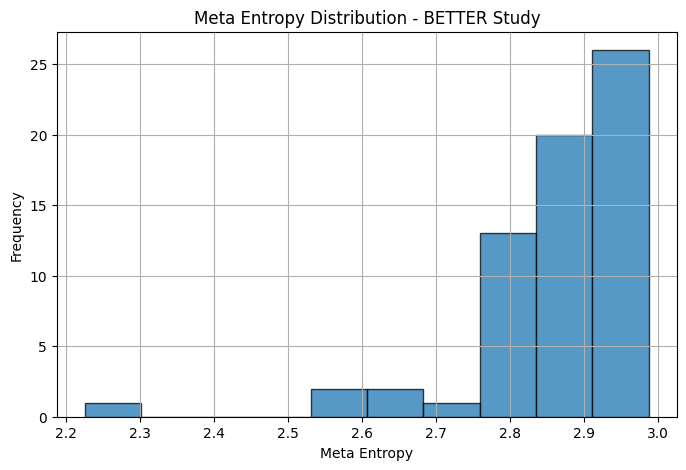

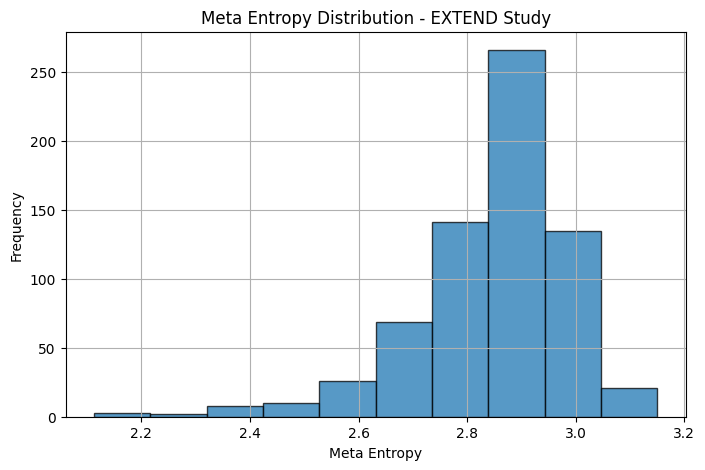

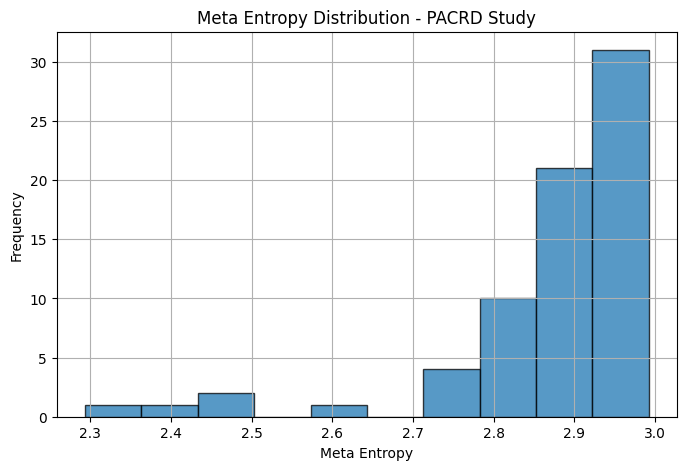

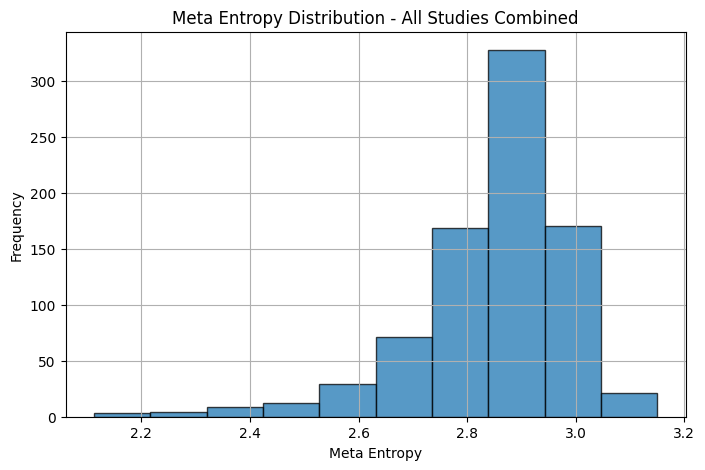

In [10]:
import matplotlib.pyplot as plt

# Plot distribution for each study
studies = summary_df['study'].unique()
for study in studies:
    study_data = summary_df[summary_df['study'] == study]['meta_entropy'].dropna()
    plt.figure(figsize=(8,5))
    plt.hist(study_data, bins=10, alpha=0.75, edgecolor='black')
    plt.title(f"Meta Entropy Distribution - {study} Study")
    plt.xlabel("Meta Entropy")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Plot distribution for all studies combined
all_data = summary_df['meta_entropy'].dropna()
plt.figure(figsize=(8,5))
plt.hist(all_data, bins=10, alpha=0.75, edgecolor='black')
plt.title("Meta Entropy Distribution - All Studies Combined")
plt.xlabel("Meta Entropy")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
